# Sideways Predictor for Options within Capital Markets

## Loading Libraries and Preprocessing Data

#### Loading Libraries and Fetching Data

In [125]:
# All required libraries
#!pip install ta
import html
import pandas as pd
import yfinance as yf
import ta
import datetime
from datetime import date, timedelta
today = date.today()

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

from sklearn.metrics import roc_curve, auc
import joblib

In [126]:
# Fetching SP500 companies
url = "https://en.wikipedia.org/wiki/List_of_S%26P_500_companies"
df = pd.read_html(url)[0]
tickers = df["Symbol"].astype(str).str.strip()

df = df.astype({"Symbol": "string",
                "Security": "string",
                "GICS Sector": "string",
                "GICS Sub-Industry": "string",
                "Headquarters Location": "string"})

df["Date added"] = pd.to_datetime(df["Date added"], errors="coerce")
df["CIK"] = pd.to_numeric(df["CIK"], errors="coerce")
df["Founded"] = pd.to_numeric(df["Founded"], errors="coerce")


In [127]:
# Helper Function for Fetching Stock Ticker
def get_stock_data(ticker):
    print("start")
    try:
        print(f"Fetching data for {ticker}...")
        stock = yf.download(ticker, period="6mo", interval="1d")
        if stock.empty:
            print(f"Skipping {ticker}: No data found")
            return None

        close_series = stock["Close"].squeeze()

        #FetchingTechnical Analysis

        # Calculate the 60-period Moving Average
        stock["MA_60"] = close_series.rolling(window=60).mean()

        # Bollinger Bands (20,2)
        stock["BB_High"] = ta.volatility.bollinger_hband(close_series)
        stock["BB_Mid"] = ta.volatility.bollinger_mavg(close_series)
        stock["BB_Low"] = ta.volatility.bollinger_lband(close_series)

        # RSI (14)
        stock["RSI_14"] = ta.momentum.RSIIndicator(close_series, window=14).rsi()

        # MACD (12,26,9)
        macd = ta.trend.MACD(close_series, window_slow=26, window_fast=12, window_sign=9)
        stock["MACD_Line"] = macd.macd()
        stock["MACD_Signal"] = macd.macd_signal()
        stock["MACD_Hist"] = macd.macd_diff()

        # Fetch the latest stock price (close price)
        price = stock["Close"].iloc[-1]


        latest = stock.iloc[-1][["MA_60", "BB_High", "BB_Mid", "BB_Low", "RSI_14", "MACD_Line", "MACD_Signal", "MACD_Hist"]].squeeze()
        latest["Ticker"] = ticker
        latest["Price"] = price
        return latest

    except Exception as e:
        print(f"Error fetching data for {ticker}: {e}")
        return None


In [128]:
# Helper Function for Fetching the Latest Price
def fetch_latest_price(symbol):
    yahoo_ticker = symbol.replace('.', '-')

    try:
        stock = yf.Ticker(yahoo_ticker)
        price = stock.history(period="1d")['Close'].iloc[-1]
        return price
    except Exception as e:
        print(f"Error fetching price for {symbol} ({yahoo_ticker}): {e}")
        return None

In [129]:
# Table structure
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    string        
 1   Security               503 non-null    string        
 2   GICS Sector            503 non-null    string        
 3   GICS Sub-Industry      503 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             503 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                461 non-null    float64       
dtypes: datetime64[ns](1), float64(1), int64(1), string(5)
memory usage: 31.6 KB


### Data Preprocessing

In [130]:
#Pooling in Technical FInancial Data into the main DataFrame
data_list = []
for ticker in tickers:

    stock_data = get_stock_data(ticker)
    if stock_data is not None:
        stock_data["Ticker"] = ticker
        data_list.append(stock_data)
# Create DataFrame
if data_list:
    df_stocks = pd.DataFrame(data_list).set_index("Ticker")
else:
    print("No valid stock data retrieved.")
# Clean the column headers
df_stocks.columns = [html.unescape(col) for col in df_stocks.columns]
df_stocks.columns = [col[0] for col in df_stocks.columns]
# Merging Technical Data with FUndamental Data into one DataFrame
dfdata = pd.merge(df, df_stocks, left_on='Symbol', right_on='Ticker', how='outer')
dfdata['Price'] = dfdata['Symbol'].apply(fetch_latest_price)

[*********************100%***********************]  1 of 1 completed

start
Fetching data for MMM...
start
Fetching data for AOS...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for ABT...


[*********************100%***********************]  1 of 1 completed


start
Fetching data for ABBV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for ACN...
start
Fetching data for ADBE...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AMD...
start
Fetching data for AES...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AFL...
start
Fetching data for A...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for APD...
start
Fetching data for ABNB...
start
Fetching data for AKAM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ALB...
start
Fetching data for ARE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ALGN...
start
Fetching data for ALLE...
start
Fetching data for LNT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for ALL...
start
Fetching data for GOOGL...
start
Fetching data for GOOG...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MO...
start
Fetching data for AMZN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AMCR...
start
Fetching data for AEE...
start
Fetching data for AEP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AXP...
start
Fetching data for AIG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for AMT...
start
Fetching data for AWK...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for AMP...
start
Fetching data for AME...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for AMGN...
start
Fetching data for APH...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ADI...
start
Fetching data for ANSS...
start
Fetching data for AON...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for APA...
start
Fetching data for APO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AAPL...
start
Fetching data for AMAT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for APTV...
start
Fetching data for ACGL...
start
Fetching data for ADM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ANET...
start
Fetching data for AJG...
start
Fetching data for AIZ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for T...
start
Fetching data for ATO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ADSK...
start
Fetching data for ADP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AZO...
start
Fetching data for AVB...
start
Fetching data for AVY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AXON...
start
Fetching data for BKR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for BALL...
start
Fetching data for BAC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for BAX...
start
Fetching data for BDX...


[*********************100%***********************]  1 of 1 completed


start
Fetching data for BRK.B...


[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BRK.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo) (Yahoo error = "No data found, symbol may be delisted")')
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Skipping BRK.B: No data found
start
Fetching data for BBY...
start
Fetching data for TECH...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for BIIB...
start
Fetching data for BLK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for BX...
start
Fetching data for BK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for BA...
start
Fetching data for BKNG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for BWA...
start
Fetching data for BSX...
start
Fetching data for BMY...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for AVGO...
start
Fetching data for BR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
ERROR:yfinance:
1 Failed download:
ERROR:yfinance:['BF.B']: YFPricesMissingError('possibly delisted; no price data found  (period=6mo)')


start
Fetching data for BRO...
start
Fetching data for BF.B...
Skipping BF.B: No data found
start
Fetching data for BLDR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for BG...
start
Fetching data for BXP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CHRW...
start
Fetching data for CDNS...
start
Fetching data for CZR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CPT...
start
Fetching data for CPB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for COF...
start
Fetching data for CAH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for KMX...
start
Fetching data for CCL...
start
Fetching data for CARR...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for CAT...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CBOE...
start
Fetching data for CBRE...
start
Fetching data for CDW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CE...
start
Fetching data for COR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CNC...
start
Fetching data for CNP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CF...
start
Fetching data for CRL...
start
Fetching data for SCHW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CHTR...
start
Fetching data for CVX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for CMG...
start
Fetching data for CB...
start
Fetching data for CHD...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CI...
start
Fetching data for CINF...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for CTAS...
start
Fetching data for CSCO...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for C...
start
Fetching data for CFG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CLX...
start
Fetching data for CME...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CMS...
start
Fetching data for KO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CTSH...
start
Fetching data for CL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CMCSA...
start
Fetching data for CAG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for COP...
start
Fetching data for ED...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for STZ...
start
Fetching data for CEG...
start
Fetching data for COO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for CPRT...
start
Fetching data for GLW...
start
Fetching data for CPAY...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CTVA...
start
Fetching data for CSGP...


[*********************100%***********************]  1 of 1 completed


start
Fetching data for COST...
start
Fetching data for CTRA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CRWD...
start
Fetching data for CCI...
start
Fetching data for CSX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CMI...
start
Fetching data for CVS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DHR...
start
Fetching data for DRI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DVA...
start
Fetching data for DAY...
start
Fetching data for DECK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DE...
start
Fetching data for DELL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DAL...
start
Fetching data for DVN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DXCM...
start
Fetching data for FANG...
start
Fetching data for DLR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DFS...
start
Fetching data for DG...
start
Fetching data for DLTR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for D...
start
Fetching data for DPZ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DOV...
start
Fetching data for DOW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DHI...
start
Fetching data for DTE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DUK...
start
Fetching data for DD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EMN...
start
Fetching data for ETN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EBAY...
start
Fetching data for ECL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EIX...
start
Fetching data for EW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for EA...
start
Fetching data for ELV...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for EMR...
start
Fetching data for ENPH...


start
Fetching data for ETR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EOG...
start
Fetching data for EPAM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EQT...
start
Fetching data for EFX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for EQIX...
start
Fetching data for EQR...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for ERIE...
start
Fetching data for ESS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EL...
start
Fetching data for EG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EVRG...
start
Fetching data for ES...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EXC...
start
Fetching data for EXPE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for EXPD...
start
Fetching data for EXR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for XOM...
start
Fetching data for FFIV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FDS...
start
Fetching data for FICO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FAST...
start
Fetching data for FRT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FDX...
start
Fetching data for FIS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FITB...
start
Fetching data for FSLR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FE...
start
Fetching data for FI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FMC...
start
Fetching data for F...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FTNT...
start
Fetching data for FTV...
start
Fetching data for FOXA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for FOX...
start
Fetching data for BEN...
start
Fetching data for FCX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GRMN...
start
Fetching data for IT...
start
Fetching data for GE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GEHC...
start
Fetching data for GEV...
start
Fetching data for GEN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GNRC...
start
Fetching data for GD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GIS...
start
Fetching data for GM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GPC...
start
Fetching data for GILD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GPN...
start
Fetching data for GL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for GDDY...
start
Fetching data for GS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HAL...
start
Fetching data for HIG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HAS...
start
Fetching data for HCA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for DOC...
start
Fetching data for HSIC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HSY...
start
Fetching data for HES...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HPE...
start
Fetching data for HLT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HOLX...
start
Fetching data for HD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HON...
start
Fetching data for HRL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HST...
start
Fetching data for HWM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HPQ...
start
Fetching data for HUBB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HUM...
start
Fetching data for HBAN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for HII...
start
Fetching data for IBM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for IEX...
start
Fetching data for IDXX...
start
Fetching data for ITW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for INCY...
start
Fetching data for IR...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for PODD...
start
Fetching data for INTC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ICE...
start
Fetching data for IFF...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for IP...
start
Fetching data for IPG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for INTU...
start
Fetching data for ISRG...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for IVZ...
start
Fetching data for INVH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for IQV...
start
Fetching data for IRM...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for JBHT...
start
Fetching data for JBL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for JKHY...
start
Fetching data for J...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for JNJ...
start
Fetching data for JCI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for JPM...
start
Fetching data for JNPR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for K...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for KVUE...
start
Fetching data for KDP...
start
Fetching data for KEY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for KEYS...
start
Fetching data for KMB...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for KIM...
start
Fetching data for KMI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for KKR...
start
Fetching data for KLAC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for KHC...
start
Fetching data for KR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LHX...
start
Fetching data for LH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LRCX...
start
Fetching data for LW...
start
Fetching data for LVS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LDOS...
start
Fetching data for LEN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LII...
start
Fetching data for LLY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LIN...
start
Fetching data for LYV...
start
Fetching data for LKQ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LMT...
start
Fetching data for L...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LOW...
start
Fetching data for LULU...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for LYB...
start
Fetching data for MTB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for MPC...
start
Fetching data for MKTX...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for MAR...
start
Fetching data for MMC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MLM...
start
Fetching data for MAS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MA...
start
Fetching data for MTCH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MKC...
start
Fetching data for MCD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MCK...
start
Fetching data for MDT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MRK...
start
Fetching data for META...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MET...
start
Fetching data for MTD...
start
Fetching data for MGM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MCHP...
start
Fetching data for MU...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MSFT...
start
Fetching data for MAA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MRNA...
start
Fetching data for MHK...
start
Fetching data for MOH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TAP...
start
Fetching data for MDLZ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MPWR...
start
Fetching data for MNST...
start
Fetching data for MCO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MS...
start
Fetching data for MOS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for MSI...
start
Fetching data for MSCI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for NDAQ...
start
Fetching data for NTAP...
start
Fetching data for NFLX...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for NEM...
start
Fetching data for NWSA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for NWS...
start
Fetching data for NEE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for NKE...
start
Fetching data for NI...


[*********************100%***********************]  1 of 1 completed


start
Fetching data for NDSN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for NSC...
start
Fetching data for NTRS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for NOC...
start
Fetching data for NCLH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for NRG...
start
Fetching data for NUE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for NVDA...



[*********************100%***********************]  1 of 1 completed

start
Fetching data for NVR...
start
Fetching data for NXPI...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ORLY...
start
Fetching data for OXY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ODFL...
start
Fetching data for OMC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ON...
start
Fetching data for OKE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ORCL...
start
Fetching data for OTIS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PCAR...
start
Fetching data for PKG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PLTR...
start
Fetching data for PANW...
start
Fetching data for PARA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PH...
start
Fetching data for PAYX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PAYC...
start
Fetching data for PYPL...
start
Fetching data for PNR...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PEP...
start
Fetching data for PFE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PCG...
start
Fetching data for PM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PSX...
start
Fetching data for PNW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PNC...
start
Fetching data for POOL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PPG...
start
Fetching data for PPL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PFG...
start
Fetching data for PG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PGR...
start
Fetching data for PLD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PRU...
start
Fetching data for PEG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for PTC...
start
Fetching data for PSA...
start
Fetching data for PHM...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for PWR...
start
Fetching data for QCOM...
start
Fetching data for DGX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for RL...
start
Fetching data for RJF...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for RTX...
start
Fetching data for O...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for REG...
start
Fetching data for REGN...



[*********************100%***********************]  1 of 1 completed


start
Fetching data for RF...
start
Fetching data for RSG...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for RMD...
start
Fetching data for RVTY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ROK...
start
Fetching data for ROL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ROP...
start
Fetching data for ROST...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for RCL...
start
Fetching data for SPGI...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for CRM...
start
Fetching data for SBAC...
start
Fetching data for SLB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for STX...
start
Fetching data for SRE...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for NOW...
start
Fetching data for SHW...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for SPG...
start
Fetching data for SWKS...
start
Fetching data for SJM...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for SW...
start
Fetching data for SNA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for SOLV...
start
Fetching data for SO...
start
Fetching data for LUV...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for SWK...
start
Fetching data for SBUX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for STT...
start
Fetching data for STLD...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for STE...
start
Fetching data for SYK...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for SMCI...
start
Fetching data for SYF...
start
Fetching data for SNPS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for SYY...
start
Fetching data for TMUS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TROW...
start
Fetching data for TTWO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TPR...
start
Fetching data for TRGP...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TGT...
start
Fetching data for TEL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TDY...
start
Fetching data for TFX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TER...
start
Fetching data for TSLA...
start
Fetching data for TXN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TPL...
start
Fetching data for TXT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TMO...
start
Fetching data for TJX...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TSCO...
start
Fetching data for TT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TDG...
start
Fetching data for TRV...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TRMB...
start
Fetching data for TFC...
start
Fetching data for TYL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for TSN...
start
Fetching data for USB...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for UBER...
start
Fetching data for UDR...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for ULTA...
start
Fetching data for UNP...
start
Fetching data for UAL...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for UPS...
start
Fetching data for URI...
start
Fetching data for UNH...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for UHS...
start
Fetching data for VLO...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for VTR...
start
Fetching data for VLTO...
start
Fetching data for VRSN...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for VRSK...
start
Fetching data for VZ...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for VRTX...
start
Fetching data for VTRS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for VICI...
start
Fetching data for V...


[*********************100%***********************]  1 of 1 completed


start
Fetching data for VST...
start
Fetching data for VMC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WRB...
start
Fetching data for GWW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WAB...
start
Fetching data for WBA...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WMT...
start
Fetching data for DIS...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WBD...
start
Fetching data for WM...
start
Fetching data for WAT...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WEC...
start
Fetching data for WFC...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WELL...
start
Fetching data for WST...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WDC...
start
Fetching data for WY...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WMB...
start
Fetching data for WTW...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for WDAY...
start
Fetching data for WYNN...
start
Fetching data for XEL...


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

start
Fetching data for XYL...
start
Fetching data for YUM...



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


start
Fetching data for ZBRA...
start
Fetching data for ZBH...
start
Fetching data for ZTS...


[*********************100%***********************]  1 of 1 completed


In [131]:
# DataFrame Structure
dfdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 503 entries, 0 to 502
Data columns (total 17 columns):
 #   Column                 Non-Null Count  Dtype         
---  ------                 --------------  -----         
 0   Symbol                 503 non-null    object        
 1   Security               503 non-null    string        
 2   GICS Sector            503 non-null    string        
 3   GICS Sub-Industry      503 non-null    string        
 4   Headquarters Location  503 non-null    string        
 5   Date added             503 non-null    datetime64[ns]
 6   CIK                    503 non-null    int64         
 7   Founded                461 non-null    float64       
 8   MA_60                  501 non-null    float64       
 9   BB_High                501 non-null    float64       
 10  BB_Mid                 501 non-null    float64       
 11  BB_Low                 501 non-null    float64       
 12  RSI_14                 501 non-null    float64       
 13  MACD_

## Creating Technical Thresholds based on industry And cleaning the main DataFrame

In [132]:
# Helper function for assigning Trend Values based on Sub Sector-Thresholds
def threshold_model(row, threshold_df):

    sector = row['GICS Sector']
    sub_industry = row['GICS Sub-Industry']
    if (sector, sub_industry) in threshold_df.index:
        sector_sub_industry_thresholds = threshold_df.loc[(sector, sub_industry)]
        if row['Normalized_Diff'] > sector_sub_industry_thresholds['Upper Threshold']:
            return 'Upward Trend'
        elif row['Normalized_Diff'] < sector_sub_industry_thresholds['Lower Threshold']:
            return 'Downward Trend'
        else:
            return 'Sideways Movement'
    else:
        return 'No Data for This Sector/Sub-Industry'

In [133]:
# Helper function for assigning Trend Values based on Sector-Thresholds
def sector_model(row, sector_threshold_df):
    sector = row['GICS Sector']
    if sector in sector_threshold_df.index:
        sector_thresholds = sector_threshold_df.loc[sector]
        if row['Normalized_Diff'] > sector_thresholds['Upper Threshold']:
            return 'Upward Trend'
        elif row['Normalized_Diff'] < sector_thresholds['Lower Threshold']:
            return 'Downward Trend'
        else:
            return 'Sideways Movement'
    else:
        return 'No Data for This Sector'

In [134]:
# Wrangling dfdata and creating thresholds by Sub-Industry norms
dfdata['Price'] = pd.to_numeric(dfdata['Price'], errors='coerce')
dfdata_cleaned = dfdata.dropna(subset=['MA_60', 'MACD_Signal', 'Price']).copy()  # Use .copy() to avoid SettingWithCopyWarning
dfdata_cleaned['Price'] = dfdata_cleaned['Price'].replace(0, 1)  # Avoid division by zero
dfdata_cleaned.loc[:, 'Normalized_Diff'] = (dfdata_cleaned['MA_60'] - dfdata_cleaned['MACD_Signal']) / dfdata_cleaned['Price']

# Group by GICS Sector and Sub-Industry, calculate thresholds
threshold_df = dfdata_cleaned.groupby(['GICS Sector', 'GICS Sub-Industry'])['Normalized_Diff'].agg(['mean', 'std'])
threshold_df['Upper Threshold'] = threshold_df['mean'] + threshold_df['std']
threshold_df['Lower Threshold'] = threshold_df['mean'] - threshold_df['std']

In [135]:
# Group by GICS Sector only, calculating mean, std, and other statistics for Normalized_Diff
sector_threshold_df = dfdata_cleaned.groupby('GICS Sector')['Normalized_Diff'].agg(['mean', 'std'])
sector_threshold_df['Upper Threshold'] = sector_threshold_df['mean'] + sector_threshold_df['std']
sector_threshold_df['Lower Threshold'] = sector_threshold_df['mean'] - sector_threshold_df['std']

In [136]:
#Applying Required Threshold Values
dfdata_cleaned['Trend Prediction'] = dfdata_cleaned.apply(threshold_model, threshold_df=threshold_df, axis=1)
dfdata_cleaned['Sector Trend Prediction'] = dfdata_cleaned.apply(sector_model, sector_threshold_df=sector_threshold_df, axis=1)

### Adding Earnings Date to Avoid Volitality

In [137]:
# Helper Function to find the Earnings Date
def get_earnings_date(symbol):
    try:
        stock = yf.Ticker(symbol)
        calendar = stock.calendar  # Fetch earnings calendar

        if 'Earnings Date' in calendar:
            earnings_dates = calendar['Earnings Date']

            if isinstance(earnings_dates, list) and len(earnings_dates) > 0:
                return earnings_dates[0]  # Get the next earnings date
            else:
                return None
        else:
            return None
    except Exception as e:
        print(f"Error fetching earnings date for {symbol}: {e}")
        return None


In [138]:
# Manipulating Data to add Data to the Dataframe
dfdata_cleaned['Date'] = pd.to_datetime('today').normalize()
dfdata_cleaned['Earnings Date'] = dfdata_cleaned['Symbol'].apply(get_earnings_date)
dfdata_cleaned['Earnings Date'] = pd.to_datetime(dfdata_cleaned['Earnings Date'], errors='coerce')
dfdata_cleaned['Time to Next Earnings'] = (dfdata_cleaned['Earnings Date'] - dfdata_cleaned['Date']).dt.days

In [139]:
#DataFrame Structure
dfdata_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
Index: 501 entries, 0 to 502
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Symbol                   501 non-null    object        
 1   Security                 501 non-null    string        
 2   GICS Sector              501 non-null    string        
 3   GICS Sub-Industry        501 non-null    string        
 4   Headquarters Location    501 non-null    string        
 5   Date added               501 non-null    datetime64[ns]
 6   CIK                      501 non-null    int64         
 7   Founded                  459 non-null    float64       
 8   MA_60                    501 non-null    float64       
 9   BB_High                  501 non-null    float64       
 10  BB_Mid                   501 non-null    float64       
 11  BB_Low                   501 non-null    float64       
 12  RSI_14                   501 non-null    

## Classification - Logistic Regression, SVM , Random Forest

### Setting up Different Models

In [140]:
# Adding a new DF and setting X and Y Values for Train and Test
df = dfdata_cleaned.copy()
df["Sideways"] = df["Trend Prediction"].map({"Sideways Movement": 1, "Upward Trend": 0, "Downward Trend": 0})
df["Sideways"] = df["Trend Prediction"].apply(lambda x: 1 if x == "Sideways Movement" else 0)
features = ["MA_60", "BB_High", "BB_Mid", "BB_Low", "RSI_14", "MACD_Line", "MACD_Signal", "MACD_Hist", "Price", "Normalized_Diff"]
X = df[features]
y = df["Sideways"]

In [141]:
df.columns

Index(['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry',
       'Headquarters Location', 'Date added', 'CIK', 'Founded', 'MA_60',
       'BB_High', 'BB_Mid', 'BB_Low', 'RSI_14', 'MACD_Line', 'MACD_Signal',
       'MACD_Hist', 'Price', 'Normalized_Diff', 'Trend Prediction',
       'Sector Trend Prediction', 'Date', 'Earnings Date',
       'Time to Next Earnings', 'Sideways'],
      dtype='object')

In [142]:
# Training and Testing data with 80-20 split and ccreating a Dictionary to store models
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

models = {
    "Logistic Regression": LogisticRegression(),

    "SVM": SVC(kernel="rbf", probability = True),
    "Random Forest": RandomForestClassifier(n_estimators=100)
}

In [143]:
# Evaluating each model
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    y_pred = model.predict(X_test_scaled)
    acc = accuracy_score(y_test, y_pred)
    print(f"\n{name} Accuracy: {acc:.4f}")
    print(classification_report(y_test, y_pred))



Logistic Regression Accuracy: 0.7921
              precision    recall  f1-score   support

           0       0.75      0.13      0.22        23
           1       0.79      0.99      0.88        78

    accuracy                           0.79       101
   macro avg       0.77      0.56      0.55       101
weighted avg       0.78      0.79      0.73       101


SVM Accuracy: 0.8218
              precision    recall  f1-score   support

           0       0.86      0.26      0.40        23
           1       0.82      0.99      0.90        78

    accuracy                           0.82       101
   macro avg       0.84      0.62      0.65       101
weighted avg       0.83      0.82      0.78       101


Random Forest Accuracy: 0.7921
              precision    recall  f1-score   support

           0       0.57      0.35      0.43        23
           1       0.83      0.92      0.87        78

    accuracy                           0.79       101
   macro avg       0.70      0.64   

### Model Performance Visualisation

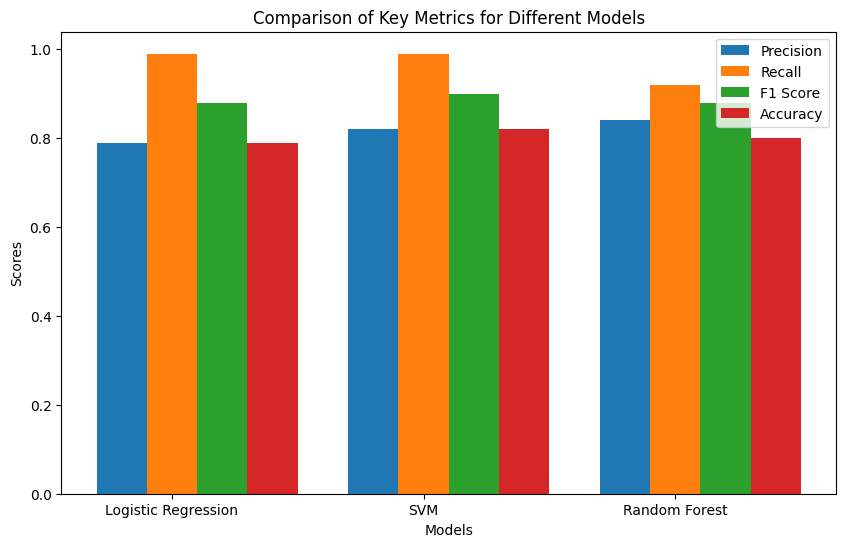

In [144]:
# Visulizing Key Statistics such as Precision, F-1 Score, Acccuracy and Recall
modelsN = ["Logistic Regression", "SVM", "Random Forest"]

# These are the precision, recall, f1-score, and accuracy for each model.
# These values are based on the output of classification_report and accuracy_score.
precision_scores = [0.79, 0.82, 0.84]
recall_scores = [0.99, 0.99, 0.92]
f1_scores = [0.88, 0.90, 0.88]
accuracy_scores = [0.79, 0.82, 0.80]

# Creating the viz
x = np.arange(len(modelsN))
width = 0.2
fig, ax = plt.subplots(figsize=(10, 6))

bars_precision = ax.bar(x - width, precision_scores, width, label='Precision')
bars_recall = ax.bar(x, recall_scores, width, label='Recall')
bars_f1 = ax.bar(x + width, f1_scores, width, label='F1 Score')
bars_accuracy = ax.bar(x + 2*width, accuracy_scores, width, label='Accuracy')
ax.set_xlabel('Models')
ax.set_ylabel('Scores')
ax.set_title('Comparison of Key Metrics for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(modelsN)
ax.legend()

plt.show()


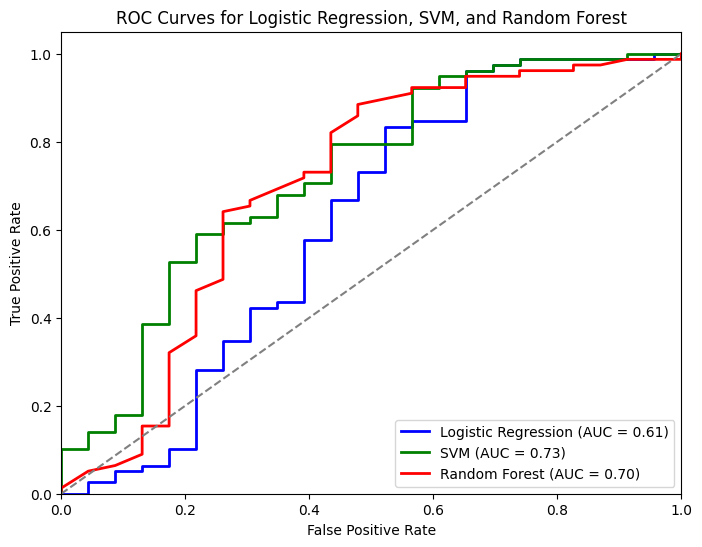

In [145]:
#Plotting the ROC for Each Model
plt.figure(figsize=(8, 6))

y_prob_logreg = models["Logistic Regression"].predict_proba(X_test_scaled)[:, 1]
fpr_logreg, tpr_logreg, thresholds_logreg = roc_curve(y_test, y_prob_logreg)
roc_auc_logreg = auc(fpr_logreg, tpr_logreg)
plt.plot(fpr_logreg, tpr_logreg, color='blue', lw=2, label=f'Logistic Regression (AUC = {roc_auc_logreg:.2f})')

# SVM ROC Curve
y_prob_svm = models["SVM"].predict_proba(X_test_scaled)[:, 1]
fpr_svm, tpr_svm, thresholds_svm = roc_curve(y_test, y_prob_svm)
roc_auc_svm = auc(fpr_svm, tpr_svm)
plt.plot(fpr_svm, tpr_svm, color='green', lw=2, label=f'SVM (AUC = {roc_auc_svm:.2f})')

# Random Forest ROC Curve
y_prob_rf = models["Random Forest"].predict_proba(X_test_scaled)[:, 1]
fpr_rf, tpr_rf, thresholds_rf = roc_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
plt.plot(fpr_rf, tpr_rf, color='red', lw=2, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Diagonal line for random guessing at AUC value of 0.5
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for Logistic Regression, SVM, and Random Forest')
plt.legend(loc='lower right')
plt.show()


## Model Deployment

In [146]:
# Adding New Data to be Implemeted in Future Scenarios

#new_data = new_data_df[features]
#new_data_scaled = scaler.transform(new_data)
#new_predictions = models["SVM"].predict(new_data_scaled)
#new_data["Prediction"] = new_predictions

#Ignore

In [147]:
# Saving the model
joblib.dump(models["SVM"], "svm_model.pkl")
joblib.dump(scaler, "scaler.pkl")

['scaler.pkl']

In [148]:
#Prediction with New Data

#new_data_scaled = scaler.transform(new_data)
#new_predictions = svm_model.predict(new_data_scaled)